In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [13]:
cards = pd.read_csv("cards.csv")

In [14]:
train_cards, test_cards = train_test_split(cards, test_size = 0.3)

In [23]:
random.seed(0)

def generate_feature(feature, dependencies):
    keys = list(dependencies.keys())    
    cards_copy = cards.copy()
    
    for key in keys:
        cards_copy = cards_copy[(cards_copy[key] == dependencies[key])]
    try:
        return random.choice(list(cards_copy[feature]))
    except IndexError as e:
        print(feature, dependencies)
        raise(e)

def generate_nontext(cards, dependency_graph):
    """Note: keys in the dependency graph point to a list of that node's parents in the 
    dependency graph. This code assumes that the dependency_graphs keys are in order such that a node
    comes before all the node's children."""
    new_card = {}
    keys = list(dependency_graph.keys())
    for feature in keys:
        dependencies = {parent : new_card[parent] for parent in dependency_graph[feature]}
        new_card[feature] = generate_feature(feature, dependencies)
    return new_card


In [16]:
dependency_graph = {"rarity":[],
                    "color":[],
                    "type":["rarity", "color"],
                    "mana_cost":["type", "color"],
                    "power":["mana_cost", "type"],
                    "toughness":["mana_cost", "type"],
                    "loyalty":["mana_cost", "type"]}

In [17]:
rarities = []
colors = []
card_types = []
mana_costs = []
powers = []
toughnesses = []
loyalties = []

for _ in tqdm(range(test_cards.shape[0])):
    card = generate_nontext(train_cards, dependency_graph)
    rarities.append(card["rarity"])
    colors.append(card["color"])
    card_types.append(card["type"])
    mana_costs.append(card["mana_cost"])
    powers.append(card["power"])
    toughnesses.append(card["toughness"])
    loyalties.append(card["loyalty"])
    
generated_cards = pd.DataFrame({"rarity":rarities, 
                                "color":colors,
                                "type":card_types,
                                "mana_cost":mana_costs,
                                "power":powers,
                                "toughness":toughnesses,
                                "loyalty":loyalties})

100%|██████████████████████████████████████████████████████████████████████████████| 5323/5323 [02:20<00:00, 38.01it/s]


In [18]:
def count_same(row, df):
    df = df.copy()
    for s in [
        "rarity", 
        "color", 
        "type",
        "mana_cost",
        #"power",
        #"toughness",
        #"loyalty"
    ]:
        df = df[(df[s] == row[s])]
    return df.shape[0]

F:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

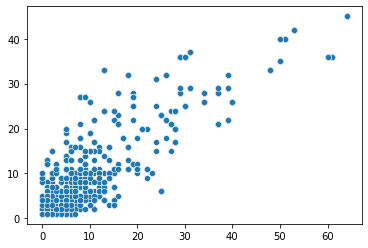

In [19]:
test_same, gen_same = [],[]
unique_generated_cards = generated_cards.drop_duplicates()
for index, row in unique_generated_cards.iterrows():
    test_same.append(count_same(row, test_cards))
    gen_same.append(count_same(row, generated_cards))

sns.scatterplot(test_same, gen_same)

In [20]:
margin = 9
reasonably_close = [g <= t+margin and g >= t-margin for t, g in zip(test_same, gen_same)]
np.mean(reasonably_close)

0.8687956906502501

In [21]:
for t_ in range(300):
    for g_ in range(300):
        count_stats = [t == t_ and g == g_ for t, g in zip(test_same, gen_same)]
        if any(count_stats):
            print(t_, g_, np.mean(count_stats))

0 1 0.15852250865717585
0 2 0.04309349749903809
0 3 0.014621008080030782
0 4 0.003847633705271258
0 5 0.003847633705271258
0 8 0.002308580223162755
0 9 0.0034628703347441324
0 10 0.0026933435936898806
1 1 0.05117352828010773
1 2 0.025009619084263177
1 3 0.0119276644863409
1 4 0.010388611004232396
1 5 0.006925740669488265
1 6 0.0061562139284340135
1 7 0.0011542901115813775
1 8 0.0007695267410542517
1 12 0.007310504040015391
1 13 0.003847633705271258
2 1 0.01385148133897653
2 2 0.018083878414774913
2 3 0.008464794151596768
2 4 0.006540977298961139
2 5 0.005386687187379761
2 6 0.001923816852635629
2 7 0.005386687187379761
2 8 0.00038476337052712584
2 9 0.0026933435936898806
2 10 0.0026933435936898806
2 15 0.007695267410542516
3 1 0.002308580223162755
3 2 0.013081954597922277
3 3 0.0034628703347441324
3 4 0.007310504040015391
3 5 0.001923816852635629
3 6 0.0034628703347441324
3 7 0.0034628703347441324
3 10 0.0030781069642170067
3 11 0.002308580223162755
3 12 0.0011542901115813775
4 1 0.003

In [22]:
generated_cards

,rarity,color,type,mana_cost,power,toughness,loyalty
0,common,B,Creature,BX,1,1,NaN
1,uncommon,G,Instant,GGXXXXXXX,NaN,NaN,NaN
2,mythic,R,Sorcery,RX,NaN,NaN,NaN
3,uncommon,G,Creature,GGXX,8,3,NaN
4,rare,G,Creature,GX,2,2,NaN
...,...,...,...,...,...,...,...
5318,uncommon,G,Creature,GXXXX,4,3,NaN
5319,common,B,Sorcery,BX,NaN,NaN,NaN
5320,uncommon,B,Sorcery,BBXXX,NaN,NaN,NaN
5321,rare,W,Enchantment,WWXX,NaN,NaN,NaN
